In [25]:
from copy import deepcopy
from random import choices, seed
from ase.visualize import view
from importlib import reload
import numpy as np
from ase import Atoms
from itertools import cycle, islice
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
import graphical
reload(graphical)
import abtem_backend as backend
reload(backend)
import ase_funcs
reload(ase_funcs)
import SingleOrigin as so
reload(so)

<module 'SingleOrigin' from 'C:\\Users\\charles\\Documents\\GitHub\\SingleOrigin\\__init__.py'>

In [ ]:
# Preview the cif file to make sure it looks right
# This pops up a new interactive window where you can rotate / pan / zoom / etc. with the cif model
cif_cell = graphical.gui_open(ffmt="cif")
view(cif_cell)
# Technically, reading the cif returns a generator (because cifs can store multiple crystal structures in one file),
# in which case this only shows the first valid structure.  But practically, just avoid using cif files with multiple structures in them

First we want to check some thin samples; with these, we can exhaustively enumerate the possible configurational variations within a column, which should give us a little bit of insight into how quickly we're losing information about the in-column chemistry.  Let's build models up to 4 projected cells thick.

In [ ]:
thin_models = backend.build_from_cif(graphical.gui_get_path(),
                                     zas=(1, 1, 0),
                                     tks=[2, 6, 8, 12],
                                     tilings=(2, 2))

In [ ]:
# Preview a model to make sure it looks right
view(thin_models[-1].atoms)

In [ ]:
chopped_models = [ase_funcs.split_by_projected_columns(model.atoms, kinds="Al") for model in thin_models]

In [ ]:
# Treat the one cell thick case specially, since we just want to pick at (pseudo)random
seed(12)  # This seed gives an actual 50:50 ratio
syms = choices(["Al", "Sc"], weights=[0.5, 0.5], k=len(chopped_models[0]))
seed(None)  # Unset the seed, so we don't mess up later steps
for i, col in enumerate(chopped_models[0]):
    col[0].symbol = syms[i]

In [ ]:
# Then, for the rest, let's exhaustively go through all possible variations and assign them to a column
# For the four cell thick case, this is 1:1; for thinner models, we will need to repeat some
for model, cm in zip(thin_models[1:], chopped_models[1:]):
    n_vars = pow(2, len(cm[0]))
    # Get variations, and unwrap the returned tuples to remove the labels (which we don't need right now)
    new_cols = [col[1] for col in ase_funcs.gen_variations(Atoms(cm[0]), subs=("Al", "Sc"))]

    if len(cm) >= n_vars:
        new_cols = list(islice(cycle(new_cols), len(cm)))  # Repeat to account for all columns
    elif len(cm) <= n_vars:
        raise ValueError("Too many possible variations; increase supercell x-y size")
    # else len(cm) == n_vars, and we don't need to change new_cols

    # ndarray for fast & easy 2D lookup
    # Index guide: [column, pos_in_col, tuple], where for tuple 0 is index in model and 1 is symbol
    cm_array = np.array([[(atom.index, atom.symbol) for atom in col] for col in cm])
    for i, col in enumerate(new_cols):
        for j, atom in enumerate(col):
            cm_array[i, j, 1] = atom.symbol
    del new_cols  # We don't need this anymore
    #  Finally, we can modify the models to have the correct elements!
    for atom in model.atoms:
        if atom.symbol in ["Al"]:
            cm_location = np.where(cm_array[:, :, 0] == str(atom.index))
            atom.symbol = cm_array[cm_location[0], cm_location[1], 1][0]


In [ ]:
# STEM simulation setup
db = backend.DetectorBuilder()
potential_parameters = backend.PotentialParameters(sampling=0.1,
                                                   slice_thickness=1,
                                                   device="gpu",
                                                   storage="cpu",
                                                   fp_cfgs=100,
                                                   fp_sigmas={"Al": 0.0567,  # DOI: 10.1107/S0108767309004966
                                                              "Sc": 0.0567,  # No good source for this, assuming the same as Al
                                                              "N":  0.0593})
# Lower convergence angle helps a little bit with chemistry, but of course there's a tradeoff with resolution
# I know I can get atomic res with 17.9, and going down to 10 only helps a small amount with chemical quantification
probe_parameters = backend.ProbeParameters(device="gpu", convergence=17.9)

In [ ]:
# STEM simulation; it's fast for models this small!  Only takes about 2 minutes
thin_results = []
for model in thin_models:
    thin_results.append(backend.sim_stem([model],
                                    db,
                                    potential_prms=potential_parameters,
                                    probe_prms=probe_parameters,
                                    kinds=["haadf"]))

In [ ]:
# Process the results into HAADF images
imgs = []
for result in thin_results:
    res = result[0]  # Unwrap single element list
    meas = res.measurement[0]
    img = meas.interpolate(tuple([x/4 for x in res.grid.sampling]), kind="fft").tile((3, 3)).array
    img = so.image_norm(img)
    imgs.append(img)

In [ ]:
# Preview one of the images, to make sure
plt.clf()
plt.imshow(imgs[3], cmap="binary")
plt.axis("off")
plt.show()

Now that we have simulated HAADF images, we'll fit with SingleOrigin as this allows us to get the integrated column intensity as a measure of chemistry at a per-column level.  There are a couple of notes here to make sure this works right:
1. When selecting FFT spots, first select the $0 0 \bar{2}$ spot (right of the origin), and then select the $1 \bar{1} 0$ spot (above the origin).  This ensures proper orientation of the unit cell with respect to the image.
2. When selecting a column as the origin of the fitted lattice, use the column just to the right of the centerline and 6 projected cells up from the bottom of the image.  This both ensures correct alignment of the unit cell with respect to the image, and ensure that some later analysis steps with hard-coded "magic numbers" work out correctly.  If done correctly, the peak should be found at image coordinates `[196, 196]`.

In [ ]:
cif_path = r"C:\Users\charles\Documents\AlScN\raw\AlN.cif"
uc = so.UnitCell(cif_path)

za = [1, 1, 0]  # Zone axis direction
a2 = [0, 0, -1]  # Apparent horizontal axis in projection
a3 = [1, -1, 0]  # Most vertical axis in projection

uc.project_zone_axis(za, a2, a3, ignore_elements=["N"])
uc.combine_prox_cols()

In [ ]:
uc.plot_unit_cell()

In [ ]:
hrimgs = [so.HRImage(img) for img in imgs]
lattices = [hrimg.add_lattice("AlN", uc) for hrimg in hrimgs]
matplotlib.use("QtAgg")
for lattice in lattices:
    lattice.fft_get_basis_vect(a1_order=2, a2_order=1, sigma=2)
%matplotlib widget

In [ ]:
matplotlib.use("QtAgg")
for lattice in lattices:
    lattice.roi_mask = np.ones(imgs[0].shape)
    lattice.define_reference_lattice()
%matplotlib widget

In [ ]:
for lattice in lattices:
    lattice.fit_atom_columns(buffer=0, local_thresh_factor=0, use_background_param=False,
                             use_bounds=True, use_circ_gauss=False, parallelize=True,
                             peak_grouping_filter=None)

    # Must have only one column per projected unit cell.  If no sublattice meets this criterion,
    #  specify a specific column in the projected cell.
    lattice.refine_reference_lattice(filter_by='elem', sites_to_use='all')

In [ ]:
# Check one of the fits to make sure everything worked
hrimgs[1].plot_atom_column_positions(scatter_kwargs_dict={"s": 20}, scalebar_len_nm=None,
                                     outlier_disp_cutoff=100, fit_or_ref="ref")

Finally, we need to analyze the images.  Unfortunately, by far the simplest way to do this is to use some "magic numbers" that correspond to our understanding of the models used to generate the images.  The magic numbers here are:
1. `sc_counts`, which hold (for each model/image) the number of Sc atoms in a projected column.  This has been done for a single supercell (i.e. not the entire $3\times 3$ tiled image).  The indices in `sc_counts` are: image/model number, $u$ coordinate (ascending), and $v$ coordinate (ascending).  The order is, of course, crucial.
2. $u_0$ and $v_0$, which are picked such that - so long as the correct origin column was chosed during the SingleOrigin fitting step - the $u$ and $v$ coordinates of one supercell are properly registered against `sc_counts`.
3. The increment lists for $u$ and $v$, which span a full supercell.  $v$ needs to be offset by $1/3$ when $u$ is an integer to properly find all columns in the supercell, which might also be considered a magic number.

In [ ]:
# These will always have the same columns, but not necessarily in the same order
# Thus, these will need to be updated whenever the models are regenerated
# View the models with this line of code, and make sure to rotate -90 degrees about the Z axis
# Then, begin from the bottom left and count upward (-X direction) first, then right (+Y direction); record the Sc counts per column
view(thin_models[3].atoms)

In [ ]:
sc_counts = [None, None, None, None]
sc_counts[0] = [[1, 0, 1, 0],
                [1, 1, 0, 0],
                [1, 0, 1, 1],
                [0, 0, 0, 1]]
sc_counts[1] = [[2, 1, 1, 1],
                [2, 1, 1, 0],
                [0, 0, 1, 1],
                [1, 2, 0, 2]]
sc_counts[2] = [[3, 2, 1, 2],
                [3, 1, 2, 2],
                [0, 2, 1, 1],
                [2, 1, 0, 1]]
sc_counts[3] = [[4, 3, 2, 2],
                [2, 2, 3, 1],
                [2, 3, 1, 1],
                [2, 1, 0, 3]]

In [ ]:
# For more convenient analysis
frames = []
for lat in lattices:
    frame = deepcopy(lat.at_cols)
    frame.drop(["site_frac", "x", "y", "weight"], axis=1, inplace=True)  # We don't need these cols
    frame.reset_index(drop=True, inplace=True)
    frames.append(frame)

In [ ]:
u0, v0 = -1.5, -2/3  # This depends on selecting the correct column in the interactive step: peak coordinates [196, 196]
us = [u0 + increment for increment in [0, 0.5, 1, 1.5]]
vs = [v0 + increment for increment in [0, 1, 2, 3]]

col_ints = []
for frame in frames:
    frame_ints = []
    for u in us:
        _ints = []
        for v in vs:
            if int(u) == u:
                # On half-integer u steps we need to bump v up by 1/3
                v = v + 1/3
            match = frame.loc[(np.isclose(frame["u"], u, atol=0.001)) & (np.isclose(frame["v"], v, atol=0.001))]
            _ints.append(float(match.total_col_int))
        frame_ints.append(_ints)
    col_ints.append(frame_ints)


In [ ]:
%matplotlib widget
which = 3  # Which thickness to plot for
clist = [count for sublist in sc_counts[which] for count in sublist]
ilist = [intensity for sublist in col_ints[which] for intensity in sublist]
plt.scatter(clist, ilist, None, "purple", "x", label="Data from Simulation")

fit = np.polyfit(clist, ilist, deg=1, full=True)
linfit_xs = np.linspace(min(clist), max(clist))
linfit_ys = linfit_xs*fit[0][0] + fit[0][1]
plt.plot(linfit_xs, linfit_ys, "g--", label=f"Linear Fit, $R^2 = ${round(1 - fit[1][0] / np.sum((ilist - np.mean(ilist))**2), 3)}")

plt.xlabel("Per-Column Scandium Count")
plt.ylabel("Integrated Column Intensity (a.u.)")
plt.xticks(np.arange(0, max(clist)+1, 1))
plt.legend()
plt.show()

In [16]:
# Measured R^2 values for several trials
# Each sublist here is a thickness, with repeats in the list representing trials
rsquareds = [[0.996, 0.997, 0.998, 0.998, 0.999],  # 1 u.c.
             [0.835, 0.852, 0.841, 0.851, 0.828],  # 2 u.c.
             [0.891, 0.916, 0.924, 0.924, 0.922],  # 3 u.c.
             [0.806, 0.765, 0.777, 0.781, 0.806]]  # 4 u.c.
rsqaureds = np.array(rsquareds).T  # Transpose so that it works with a simple call to boxplot

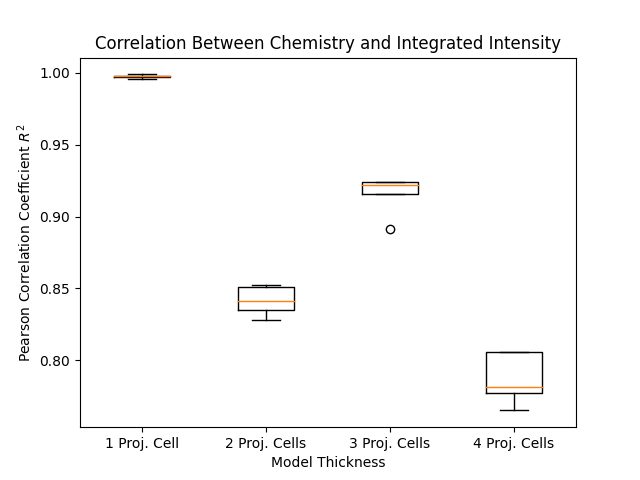

In [17]:
%matplotlib widget
labs = ["1 Proj. Cell", "2 Proj. Cells", "3 Proj. Cells", "4 Proj. Cells"]
fig, ax = plt.subplots()
ax.boxplot(rsquareds)
ax.set_xticklabels(labs)
ax.set_ylabel("Pearson Correlation Coefficient $R^2$")
ax.set_xlabel("Model Thickness")
plt.title("Correlation Between Chemistry and Integrated Intensity")
plt.show()

After having a look at this data, here are some tentative conclusions:
1. The single-layer spread (associated with frozen phonons and local neighborhood) is capping $R^2 \approx 0.998$ with a narrow spread -- not perfect of course, but quite good!
2. For thicker samples, ordering and probe spread effects start to come into play.  Lower convergence angles help with this, but of course at some point we will lose atomic resolution which defeats the purpose.  I know 17.9 will give resolved columns, so I'll stick with that.
3. I can't quite figure out why 3 projected cells has a better correlation than 2 projected cells; I think it may have to do with the increased distance between the integrated intensity for a column with no Sc and a column with 3 Sc (compared to the max of 2 Sc in the 2 projected cells case), in which case the reductin in correlation for the 4-cell thick case suggests that ordering effects will, in the long run, outpace the effect of this increased distance.

This is reasonable for now; at this point it's probably best to start working on thicker simulations to see where we end up with much thicker samples.  These will be more realistic for actual TEM samples, which aren't often less than 10nm thick.  I'll test a range from 10nm to 30nm thick, with Sc content from 10% to 30%, and each trial will get 32 trials.  Doing it this way means I can simulate 4 different columns in each image, leading to 8 trials per condition.  I'll also take special account of the endmembers (0% Sc and 100% Sc) to put bounds on where integrated intensity values can fall for each thickness, and get an idea of how much intensity spread there is due to non-chemistry effects.

In [2]:
# Random seeds from random.org (x32)
seeds = [87353, 39801, 56916, 62903, 76446, 40231, 92312, 43299,
         72148, 37976, 93458, 22838, 78787, 89538, 53240, 82349,
         85799, 94281, 53053, 10655, 94124, 6828, 21401, 75500,
         7576, 74045, 70885, 23437, 25341, 59347, 23364, 96399]

conditions = [{"t": 100, "c": 0.1}, {"t": 100, "c": 0.2}, {"t": 100, "c": 0.3},  # t => thickness, c => chemistry (Sc %)
              {"t": 200, "c": 0.1}, {"t": 200, "c": 0.2}, {"t": 200, "c": 0.3},
              {"t": 300, "c": 0.1}, {"t": 300, "c": 0.2}, {"t": 300, "c": 0.3},
              {"t": 100, "c": 0.0}, {"t": 200, "c": 0.0}, {"t": 300, "c": 0.0},  # Wurtzite AlN endmember
              {"t": 100, "c": 1.0}, {"t": 200, "c": 1.0}, {"t": 300, "c": 1.0}]  # Wurtzite ScN endmember

# 32 trials per condition w/ 4 trials per sim ==> 120 simulations!  Even if they only take a few minutes each, this will be slow
# Thus this will need to be done in a loop, and measurements should be saved to a file after each simulation in case of a crash

In [9]:
thick_models = backend.build_from_cif(graphical.gui_get_path(),
                                      zas=(1, 1, 0),
                                      tks=[conditions[i]["t"] for i in range(len(conditions))],
                                      tilings=(1, 1))

In [26]:
# Warning: reusing this name, be careful of running this out of order
chopped_models = [ase_funcs.split_by_projected_columns(model.atoms, kinds="Al") for model in thick_models]

for cm, cond, model, seed in zip(chopped_models, conditions, thick_models, seeds):
    new_cols = []
    for col in cm:
        column = ase_funcs.randomize_chem(Atoms(col), replacements={"Al": {"Sc": cond["c"]}}, prseed=seed)
        new_cols.append(column)

    swap_list = []
    for new_col, old_col in zip(new_cols, cm):
        for new_atom, old_atom in zip(new_col, old_col):
            swap_list.append({"idx": old_atom.index, "sym": new_atom.symbol})
    del new_cols  # We don't need this anymore

    for atom in model.atoms:
        if atom.symbol in ["Al"]:
            new_symbol = next(entry["sym"] for entry in swap_list if entry["idx"] == atom.index)
            atom.symbol = new_symbol